C:\Users\meteh\AppData\Local\Temp\ipykernel_16592\1211550429.py:9: ParserWarning: Skipping line 10: expected 5 fields, saw 10

  true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")


Doğru veri CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
LLM tahmin CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırı

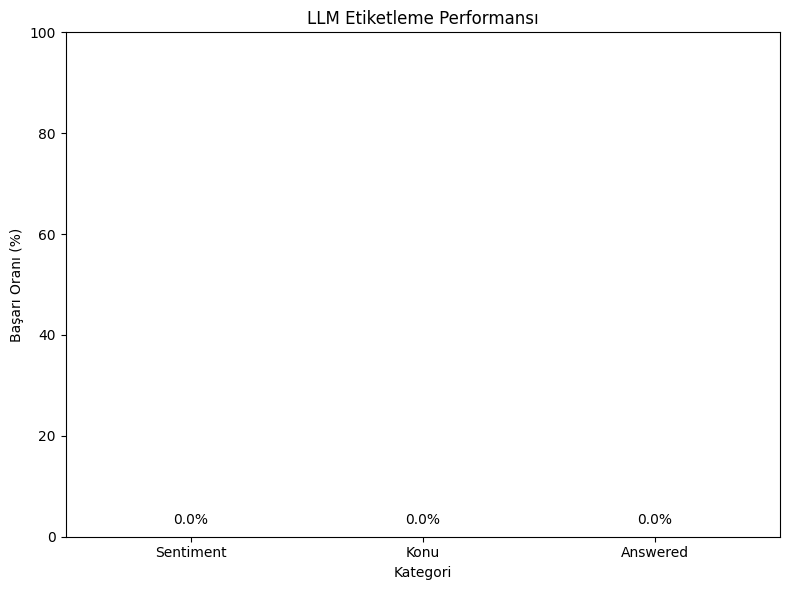

Sentiment Başarı Oranı: 0.0%
Konu Başarı Oranı: 0.0%
Answered Başarı Oranı: 0.0%


: 

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from ast import literal_eval
import csv

# CSV dosyalarını oku
try:
    true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: manuel_labels.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen manuel_labels_duzeltilmis.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

try:
    llm_predictions_df = pd.read_csv("llama-3.3-70b-versatile_output1.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: llama-3.3-70b-versatile_output1.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen llm_predictions.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

# Sütun isimlerini kontrol et
print("Doğru veri CSV sütunları:", true_df.columns.tolist())
print("LLM tahmin CSV sütunları:", llm_predictions_df.columns.tolist())

# Gerekli sütunların varlığını kontrol et
required_columns = ["konusma", "birlesik_mesaj", "sentiment", "konu", "answered"]
if not all(col in true_df.columns for col in required_columns):
    print(f"Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {true_df.columns.tolist()}")
    exit()
if not all(col in llm_predictions_df.columns for col in required_columns):
    print(f"Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {llm_predictions_df.columns.tolist()}")
    exit()

# NaN değerleri doldur
for df in [true_df, llm_predictions_df]:
    df["sentimen"] = df["sentimen"].fillna("nötr")
    df["konu"] = df["konu"].fillna("[etkinlik belirtilmemiş]")
    df["answered"] = df["answered"].fillna("Hayır")

# JSON verisi oluştur
json_data = []
for idx, row in true_df.iterrows():
    llm_row = llm_predictions_df[llm_predictions_df["konusma"] == row["konusma"]]
    if not llm_row.empty:
        json_entry = {
            "message": row["birlesik_mesaj"],
            "expected": {
                "sentiment": row["sentimen"],
                "topic": row["konu"],
                "bot_answered": row["answered"]
            },
            "llm_prediction": {
                "sentiment": llm_row["sentimen"].iloc[0],
                "topic": llm_row["konu"].iloc[0],
                "bot_answered": llm_row["answered"].iloc[0]
            }
        }
        json_data.append(json_entry)
    else:
        print(f"Uyarı: {row['konusma']} için LLM tahmini bulunamadı.")

# JSON dosyasına kaydet
with open("llm_karsilastirma_llama-3.3-70b-versatile.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2)

# Başarı oranlarını hesapla
sentiment_dogru = 0
konu_dogru = 0
answered_dogru = 0
toplam = len(json_data)

for item in json_data:
    # Sentiment kıyaslaması
    if item["expected"]["sentiment"] == item["llm_prediction"]["sentiment"]:
        sentiment_dogru += 1
    
    # Konu kıyaslaması (en az bir etiket eşleşirse doğru)
    try:
        expected_topics = literal_eval(item["expected"]["topic"])
        predicted_topics = literal_eval(item["llm_prediction"]["topic"])
        if any(topic in expected_topics for topic in predicted_topics):
            konu_dogru += 1
    except (ValueError, SyntaxError):
        print(f"Hata: {item['message'][:50]}... için konu listesi ayrıştırılamadı.")
    
    # Answered kıyaslaması
    if item["expected"]["bot_answered"] == item["llm_prediction"]["bot_answered"]:
        answered_dogru += 1

# Başarı oranları (%)
sentiment_basari = (sentiment_dogru / toplam) * 100 if toplam > 0 else 0
konu_basari = (konu_dogru / toplam) * 100 if toplam > 0 else 0
answered_basari = (answered_dogru / toplam) * 100 if toplam > 0 else 0

# Matplotlib ile görselleştirme
kategoriler = ["Sentiment", "Konu", "Answered"]
basari_oranlari = [sentiment_basari, konu_basari, answered_basari]

plt.figure(figsize=(8, 6))
bars = plt.bar(kategoriler, basari_oranlari, color=["#36A2EB", "#FFCE56", "#FF6384"])
plt.xlabel("Kategori")
plt.ylabel("Başarı Oranı (%)")
plt.title("LLM Etiketleme Performansı")
plt.ylim(0, 100)

# Çubukların üzerine yüzde değerlerini ekle
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("llm_basari_oranlari.png")
plt.show()

# Başarı oranlarını yazdır
print(f"Sentiment Başarı Oranı: {sentiment_basari:.1f}%")
print(f"Konu Başarı Oranı: {konu_basari:.1f}%")
print(f"Answered Başarı Oranı: {answered_basari:.1f}%")

C:\Users\meteh\AppData\Local\Temp\ipykernel_4424\1952256345.py:9: ParserWarning: Skipping line 10: expected 5 fields, saw 10

  true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")


Doğru veri CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
LLM tahmin CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırı

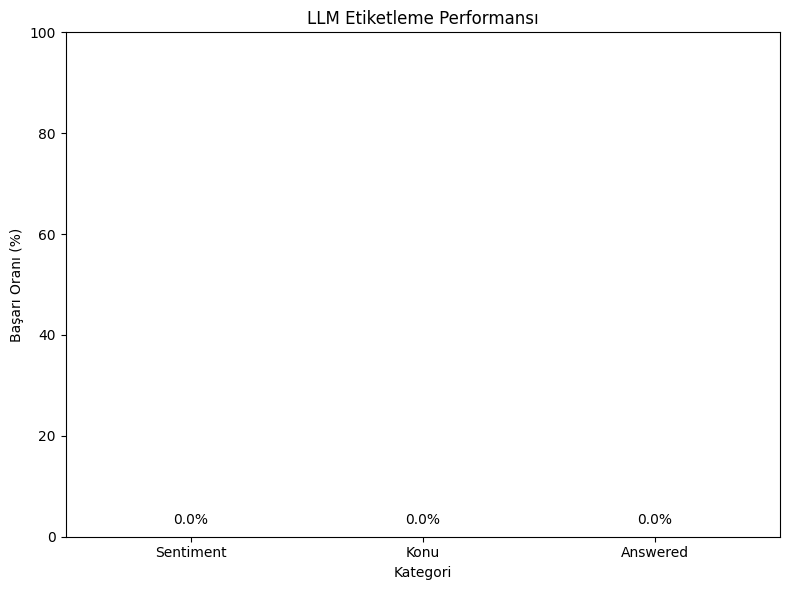

Sentiment Başarı Oranı: 0.0%
Konu Başarı Oranı: 0.0%
Answered Başarı Oranı: 0.0%


: 

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from ast import literal_eval
import csv

# CSV dosyalarını oku
try:
    true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: manuel_labels.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen manuel_labels_duzeltilmis.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

try:
    llm_predictions_df = pd.read_csv("llmGemmaOutput1.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: llmGemmaOutput1.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen llm_predictions.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

# Sütun isimlerini kontrol et
print("Doğru veri CSV sütunları:", true_df.columns.tolist())
print("LLM tahmin CSV sütunları:", llm_predictions_df.columns.tolist())

# Gerekli sütunların varlığını kontrol et
required_columns = ["konusma", "birlesik_mesaj", "sentiment", "konu", "answered"]
if not all(col in true_df.columns for col in required_columns):
    print(f"Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {true_df.columns.tolist()}")
    exit()
if not all(col in llm_predictions_df.columns for col in required_columns):
    print(f"Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {llm_predictions_df.columns.tolist()}")
    exit()

# NaN değerleri doldur
for df in [true_df, llm_predictions_df]:
    df["sentimen"] = df["sentimen"].fillna("nötr")
    df["konu"] = df["konu"].fillna("[etkinlik belirtilmemiş]")
    df["answered"] = df["answered"].fillna("Hayır")

# JSON verisi oluştur
json_data = []
for idx, row in true_df.iterrows():
    llm_row = llm_predictions_df[llm_predictions_df["konusma"] == row["konusma"]]
    if not llm_row.empty:
        json_entry = {
            "message": row["birlesik_mesaj"],
            "expected": {
                "sentiment": row["sentimen"],
                "topic": row["konu"],
                "bot_answered": row["answered"]
            },
            "llm_prediction": {
                "sentiment": llm_row["sentimen"].iloc[0],
                "topic": llm_row["konu"].iloc[0],
                "bot_answered": llm_row["answered"].iloc[0]
            }
        }
        json_data.append(json_entry)
    else:
        print(f"Uyarı: {row['konusma']} için LLM tahmini bulunamadı.")

# JSON dosyasına kaydet
with open("llm_karsilastirma_Gemma.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2)

# Başarı oranlarını hesapla
sentiment_dogru = 0
konu_dogru = 0
answered_dogru = 0
toplam = len(json_data)

for item in json_data:
    # Sentiment kıyaslaması
    if item["expected"]["sentiment"] == item["llm_prediction"]["sentiment"]:
        sentiment_dogru += 1
    
    # Konu kıyaslaması (en az bir etiket eşleşirse doğru)
    try:
        expected_topics = literal_eval(item["expected"]["topic"])
        predicted_topics = literal_eval(item["llm_prediction"]["topic"])
        if any(topic in expected_topics for topic in predicted_topics):
            konu_dogru += 1
    except (ValueError, SyntaxError):
        print(f"Hata: {item['message'][:50]}... için konu listesi ayrıştırılamadı.")
    
    # Answered kıyaslaması
    if item["expected"]["bot_answered"] == item["llm_prediction"]["bot_answered"]:
        answered_dogru += 1

# Başarı oranları (%)
sentiment_basari = (sentiment_dogru / toplam) * 100 if toplam > 0 else 0
konu_basari = (konu_dogru / toplam) * 100 if toplam > 0 else 0
answered_basari = (answered_dogru / toplam) * 100 if toplam > 0 else 0

# Matplotlib ile görselleştirme
kategoriler = ["Sentiment", "Konu", "Answered"]
basari_oranlari = [sentiment_basari, konu_basari, answered_basari]

plt.figure(figsize=(8, 6))
bars = plt.bar(kategoriler, basari_oranlari, color=["#36A2EB", "#FFCE56", "#FF6384"])
plt.xlabel("Kategori")
plt.ylabel("Başarı Oranı (%)")
plt.title("LLM Etiketleme Performansı")
plt.ylim(0, 100)

# Çubukların üzerine yüzde değerlerini ekle
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("llm_basari_oranlari.png")
plt.show()

# Başarı oranlarını yazdır
print(f"Sentiment Başarı Oranı: {sentiment_basari:.1f}%")
print(f"Konu Başarı Oranı: {konu_basari:.1f}%")
print(f"Answered Başarı Oranı: {answered_basari:.1f}%")

C:\Users\meteh\AppData\Local\Temp\ipykernel_348\3938789404.py:9: ParserWarning: Skipping line 10: expected 5 fields, saw 10

  true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")


Doğru veri CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
LLM tahmin CSV sütunları: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: ['konusma', 'birlesik_mesaj', 'sentimen', 'konu', 'answered']
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Merhaba, ben Hera. Size uy... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırılamadı.
Hata: Gönderici: bot - Mesaj: Ne tür bir etkinlik yapmay... için konu listesi ayrıştırı

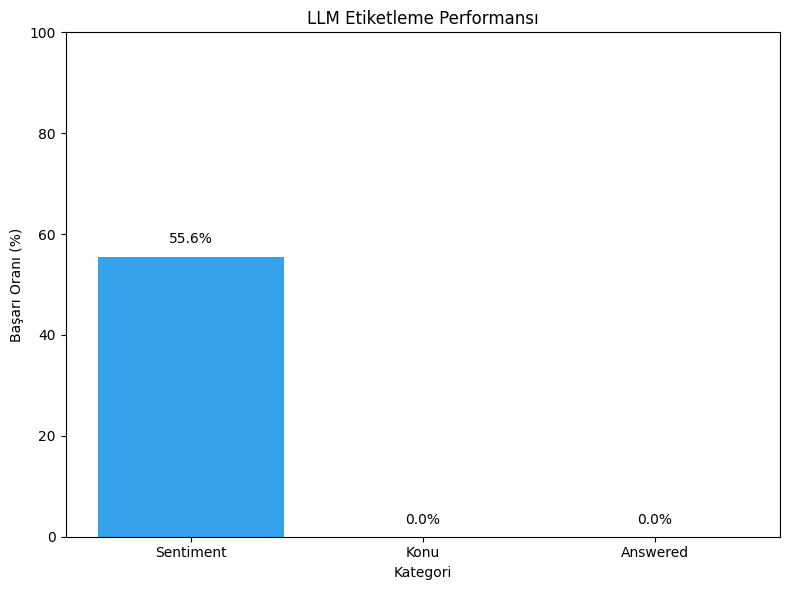

Sentiment Başarı Oranı: 55.6%
Konu Başarı Oranı: 0.0%
Answered Başarı Oranı: 0.0%


: 

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from ast import literal_eval
import csv

# CSV dosyalarını oku
try:
    true_df = pd.read_csv("manuel_labels.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: manuel_labels.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen manuel_labels_duzeltilmis.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

try:
    llm_predictions_df = pd.read_csv("gpt-5-nano.csv", quoting=csv.QUOTE_ALL, on_bad_lines="warn")
except FileNotFoundError:
    print("Hata: gpt-5-nano.csv dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()
except pd.errors.ParserError as e:
    print(f"Hata: CSV ayrıştırma hatası: {e}")
    print("Lütfen llm_predictions.csv dosyasını kontrol edin (virgülle ayrılmış, tırnaklarla çevrili metinler).")
    exit()

# Sütun isimlerini kontrol et
print("Doğru veri CSV sütunları:", true_df.columns.tolist())
print("LLM tahmin CSV sütunları:", llm_predictions_df.columns.tolist())

# Gerekli sütunların varlığını kontrol et
required_columns = ["konusma", "birlesik_mesaj", "sentiment", "konu", "answered"]
if not all(col in true_df.columns for col in required_columns):
    print(f"Hata: Doğru veri CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {true_df.columns.tolist()}")
    exit()
if not all(col in llm_predictions_df.columns for col in required_columns):
    print(f"Hata: LLM tahmin CSV'sinde gerekli sütunlar eksik. Bulunan sütunlar: {llm_predictions_df.columns.tolist()}")
    exit()

# NaN değerleri doldur
for df in [true_df, llm_predictions_df]:
    df["sentimen"] = df["sentimen"].fillna("nötr")
    df["konu"] = df["konu"].fillna("[etkinlik belirtilmemiş]")
    df["answered"] = df["answered"].fillna("Hayır")

# JSON verisi oluştur
json_data = []
for idx, row in true_df.iterrows():
    llm_row = llm_predictions_df[llm_predictions_df["konusma"] == row["konusma"]]
    if not llm_row.empty:
        json_entry = {
            "message": row["birlesik_mesaj"],
            "expected": {
                "sentiment": row["sentimen"],
                "topic": row["konu"],
                "bot_answered": row["answered"]
            },
            "llm_prediction": {
                "sentiment": llm_row["sentimen"].iloc[0],
                "topic": llm_row["konu"].iloc[0],
                "bot_answered": llm_row["answered"].iloc[0]
            }
        }
        json_data.append(json_entry)
    else:
        print(f"Uyarı: {row['konusma']} için LLM tahmini bulunamadı.")

# JSON dosyasına kaydet
with open("llm_karsilastirma_gpt-5-nano.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2)

# Başarı oranlarını hesapla
sentiment_dogru = 0
konu_dogru = 0
answered_dogru = 0
toplam = len(json_data)

for item in json_data:
    # Sentiment kıyaslaması
    if item["expected"]["sentiment"] == item["llm_prediction"]["sentiment"]:
        sentiment_dogru += 1
    
    # Konu kıyaslaması (en az bir etiket eşleşirse doğru)
    try:
        expected_topics = literal_eval(item["expected"]["topic"])
        predicted_topics = literal_eval(item["llm_prediction"]["topic"])
        if any(topic in expected_topics for topic in predicted_topics):
            konu_dogru += 1
    except (ValueError, SyntaxError):
        print(f"Hata: {item['message'][:50]}... için konu listesi ayrıştırılamadı.")
    
    # Answered kıyaslaması
    if item["expected"]["bot_answered"] == item["llm_prediction"]["bot_answered"]:
        answered_dogru += 1

# Başarı oranları (%)
sentiment_basari = (sentiment_dogru / toplam) * 100 if toplam > 0 else 0
konu_basari = (konu_dogru / toplam) * 100 if toplam > 0 else 0
answered_basari = (answered_dogru / toplam) * 100 if toplam > 0 else 0

# Matplotlib ile görselleştirme
kategoriler = ["Sentiment", "Konu", "Answered"]
basari_oranlari = [sentiment_basari, konu_basari, answered_basari]

plt.figure(figsize=(8, 6))
bars = plt.bar(kategoriler, basari_oranlari, color=["#36A2EB", "#FFCE56", "#FF6384"])
plt.xlabel("Kategori")
plt.ylabel("Başarı Oranı (%)")
plt.title("LLM Etiketleme Performansı")
plt.ylim(0, 100)

# Çubukların üzerine yüzde değerlerini ekle
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f"{yval:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("llm_basari_oranlari.png")
plt.show()

# Başarı oranlarını yazdır
print(f"Sentiment Başarı Oranı: {sentiment_basari:.1f}%")
print(f"Konu Başarı Oranı: {konu_basari:.1f}%")
print(f"Answered Başarı Oranı: {answered_basari:.1f}%")